d:\miniconda3\envs\pytorch311\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


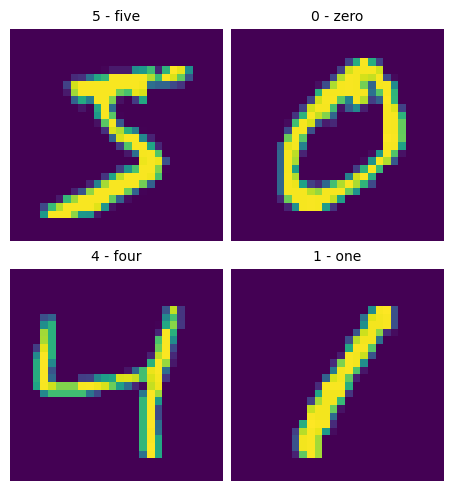

15738
path                                         module                                       input size               output size              params    buffers   
__main__.CNN/c1/0                            torch.nn.modules.conv.Conv2d                 (1, 1, 28, 28)           (1, 16, 25, 25)          272       0         
__main__.CNN/c1/1                            torch.nn.modules.pooling.MaxPool2d           (1, 16, 25, 25)          (1, 16, 12, 12)          0         0         
__main__.CNN/c1/2                            torch.nn.modules.activation.ReLU             (1, 16, 12, 12)          (1, 16, 12, 12)          0         0         
__main__.CNN/c2/0                            torch.nn.modules.conv.Conv2d                 (1, 16, 12, 12)          (1, 32, 10, 10)          4640      0         
__main__.CNN/c2/1                            torch.nn.modules.pooling.MaxPool2d           (1, 32, 10, 10)          (1, 32, 5, 5)            0         0         
__main__.CNN/c2/2           

In [1]:
from glio.imports import *
from glio.importsglio import *

from glio.datasets import MNIST
dstrain, dstest = MNIST.get_mnist_classification()
dstrain.preview()

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = conv(1, 16, 4, 1, act=nn.ReLU(), pool=nn.MaxPool2d(2,2))
        self.c2 = conv(16, 32, 3, 1, act=nn.ReLU(), pool=nn.MaxPool2d(2, 2))
        self.c3 = conv(32, 64, 2, 1, act=nn.ReLU(), pool=nn.MaxPool2d(2, 2))
        self.linear = linear(256, 10, act=nn.Softmax(dim=1), flatten=True)
    
    def forward(self,x):
        x = self.c1(x)
        x = self.c2(x)
        x = self.c3(x)
        x = self.linear(x)
        return x

print(count_parameters(CNN()))
summary(CNN(), (1, 1, 28,28))
#torchinfo.summary(CNN(), (1, 1, 40))

# Rademacher - 62%
sampling from normal distribution achieved 68% accuracy, can other random generators beat it? Starting with rademacher, which means every number is 50% to be 1 and 50% to be -1

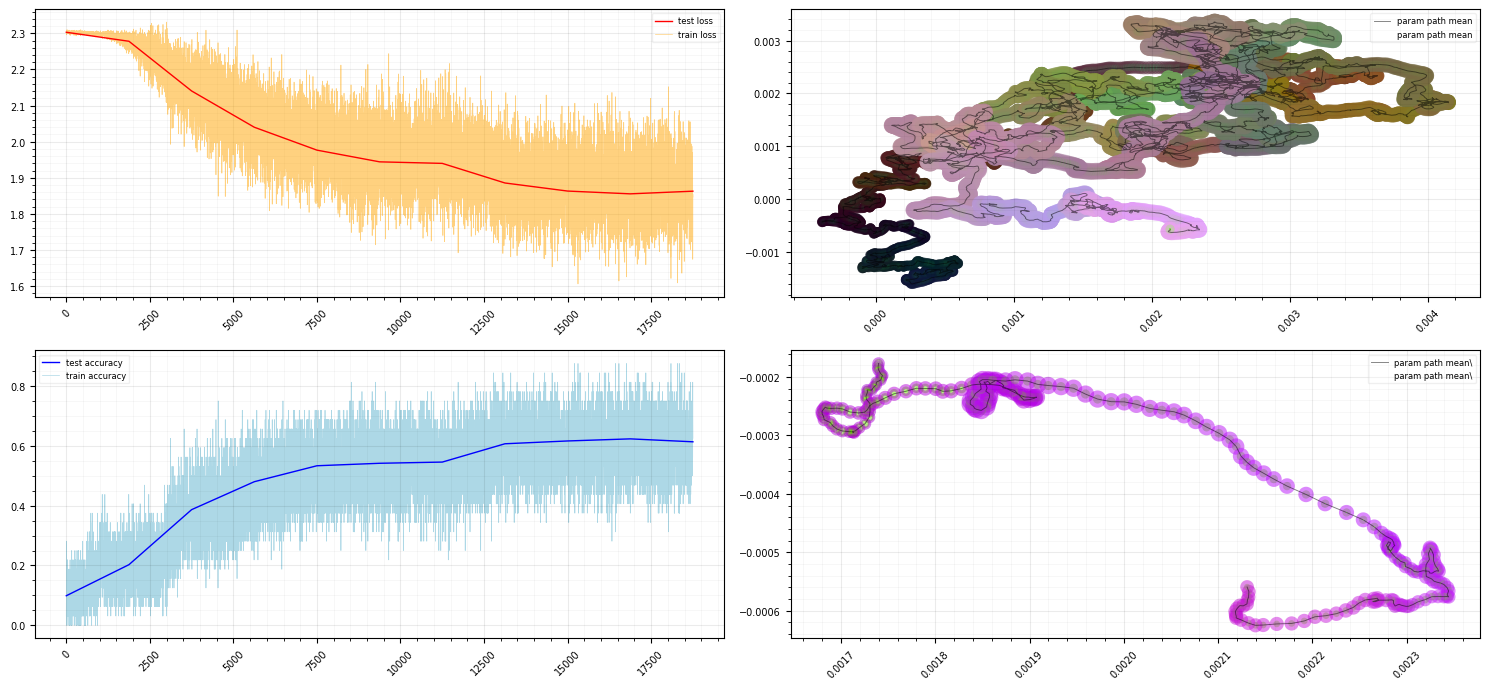

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉     | 10/10 | 48.99s/ops, elapsed: 07m:20s, rem: 48.99s | 

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 313/313 | 229.80ops/s, elapsed: 1.36s, rem: 4ms | 
train loss:                              last = 1.847, min = 1.606, max = 2.331
test loss:                               last = 1.856, min = 1.856, max = 2.303
train accuracy:                          last = 0.625, min = 0.000, max = 0.875
test accuracy:                           last = 0.623, min = 0.099, max = 0.623

test loss: min: 1.8555; max: 2.3029; last: 1.8629
test accuracy: min: 0.0989; max: 0.6232; last: 0.6134
param mean: min: -0.0001; max: 0.0040; last: 0.0039
param var: min: 0.0026; max: 0.0179; last: 0.0179
param min: min: -0.4991; max: -0.2492; last: -0.4607
param max: min: 0.2472; max: 0.6084; last: 0.5381
update var: min: 0.0000; max: 0.0000; last: 0.0000
update angle: min: 0.0017; max: 0.0195; last: 0.0017
time: min: 1.3493; max: 493.0630; last: 493.0630
train loss: min: 1.6061; max: 2.3311; last: 1.8466
train accuracy: min: 0.0000; max: 0.8750; last: 0.6250
last updates std: min: 0.0000; max: 0.0005; last: 0.0000


In [3]:
from torchzero.optim import RandomGrad
from torchzero.random import rademacher_like
with seeded_rng(): MODEL = CNN()
MAGN = 1e-5
LR = 1e-3
BATCH_SIZE = 32
N_EPOCHS = 10
LOSS_FN = nn.CrossEntropyLoss()
METRIC_STEP = 1

OPT = RandomGrad(MODEL.parameters(), magn=MAGN, sampler=rademacher_like, opt=optim.AdamW(MODEL.parameters(), LR))
#SCHED = lr_scheduler.CosineAnnealingLR(OPT, N_EPOCHS)
SCHED = None

CALLBACKS = (Metric_Loss(),
            Metric_Accuracy(True,False),
            Log_ParamDist(METRIC_STEP),
            Log_ParamPath(METRIC_STEP),
            Log_UpdateDist(METRIC_STEP),
            Log_UpdatePath(METRIC_STEP),
            Log_LastUpdatesAngle(METRIC_STEP),
            #Log_GradDist(METRIC_STEP),
            #Log_GradUpdateAngle(METRIC_STEP),
            #Log_GradPath(METRIC_STEP),
            #Log_LastGradsAngle(METRIC_STEP),
            Log_Time(),
            #Log_LR(),
            Summary(),
            Accelerate("no"),
            PerformanceTweaks(True),
            Save_Last(),
            LivePlot(1000, plot_keys = ("4plotsplot","10metrics01"),path_keys=("4plotspath250",)),
            SimpleProgressBar(),
            PlotSummary(),
            GradientFreeWithZeroGrad(),
            OneBatch_ClosureWithNoBackward()
              )
clean_mem()

with seeded_rng():
    DLTRAIN = DataLoader(dstrain, BATCH_SIZE, shuffle=True, **seed0_kwargs)
    DLTEST = DataLoader(dstest, BATCH_SIZE, shuffle=False, **seed0_kwargs)

# MODEL = gnn.LSUV(MODEL, DLTRAIN, max_iter=5)

LEARNER_NAME = f"RandomGrad {MAGN:.0e} adamw{LR:.0e} - rademacher"
learner = Learner(MODEL, LEARNER_NAME, CALLBACKS, loss_fn=LOSS_FN, optimizer=OPT, scheduler=SCHED, )
learner.fit(N_EPOCHS, DLTRAIN, DLTEST,test_on_interrupt=False)

# Randgaussian with sigma=3
We use normally distributed random values smoothed by a gaussian filter

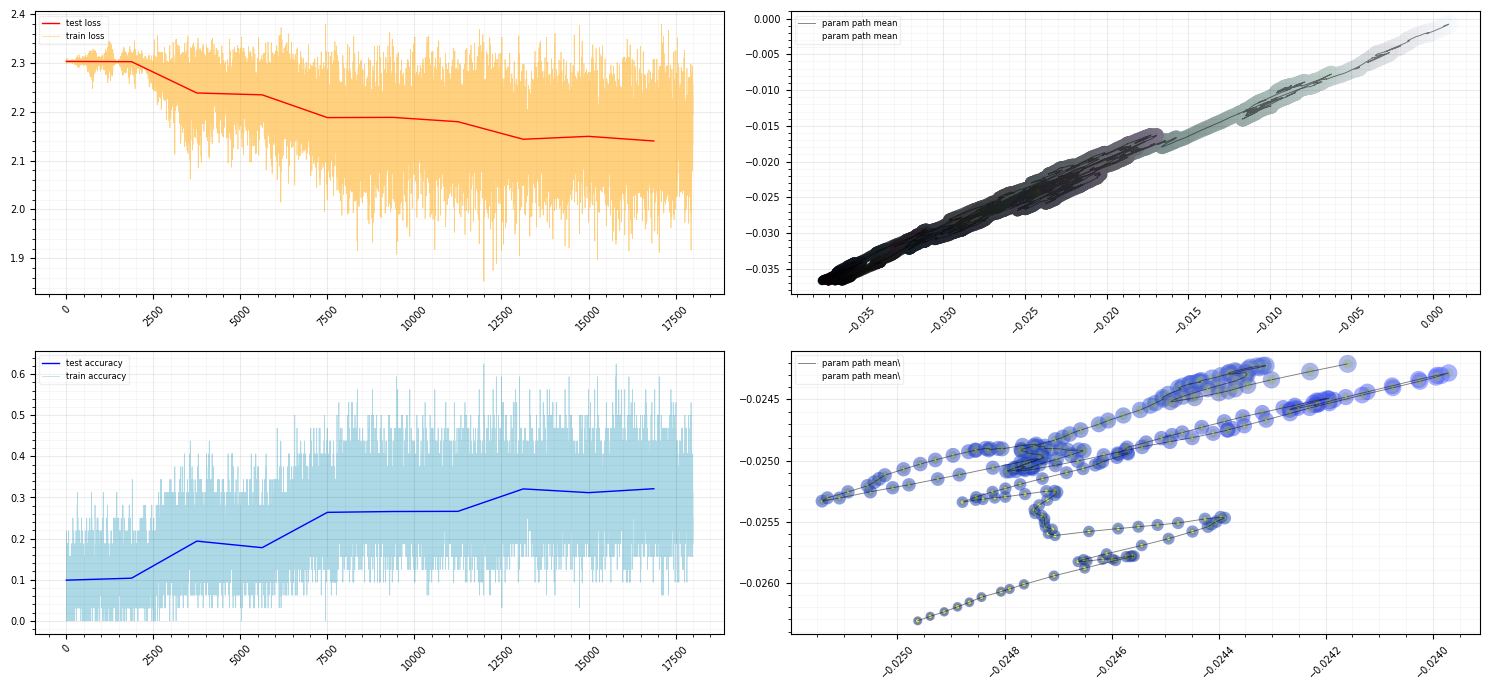

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉     | 10/10 | 01m:01s/ops, elapsed: 09m:10s, rem: 01m:01s | 

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 313/313 | 230.09ops/s, elapsed: 1.36s, rem: 4ms | 
train loss:                              last = 2.201, min = 1.853, max = 2.387
test loss:                               last = 2.140, min = 2.140, max = 2.303
train accuracy:                          last = 0.250, min = 0.000, max = 0.625
test accuracy:                           last = 0.321, min = 0.099, max = 0.321

test loss: min: 2.1401; max: 2.3029; last: 2.1664
test accuracy: min: 0.0989; max: 0.3213; last: 0.2880
param mean: min: -0.0382; max: 0.0008; last: -0.0253
param var: min: 0.0026; max: 0.0196; last: 0.0194
param min: min: -0.4760; max: -0.2361; last: -0.4334
param max: min: 0.2421; max: 0.5536; last: 0.5370
update var: min: 0.0000; max: 0.0000; last: 0.0000
update angle: min: 0.0012; max: 0.0195; last: 0.0017
time: min: 1.9896; max: 618.1532; last: 618.1532
train loss: min: 1.8533; max: 2.3870; last: 2.2010
train accuracy: min: 0.0000; max: 0.6250; last: 0.2500
last updates std: min: 0.0000; max: 0.0003; last: 0.0001


PicklingError: Can't pickle <function <lambda> at 0x000001A0472F37E0>: attribute lookup <lambda> on __main__ failed

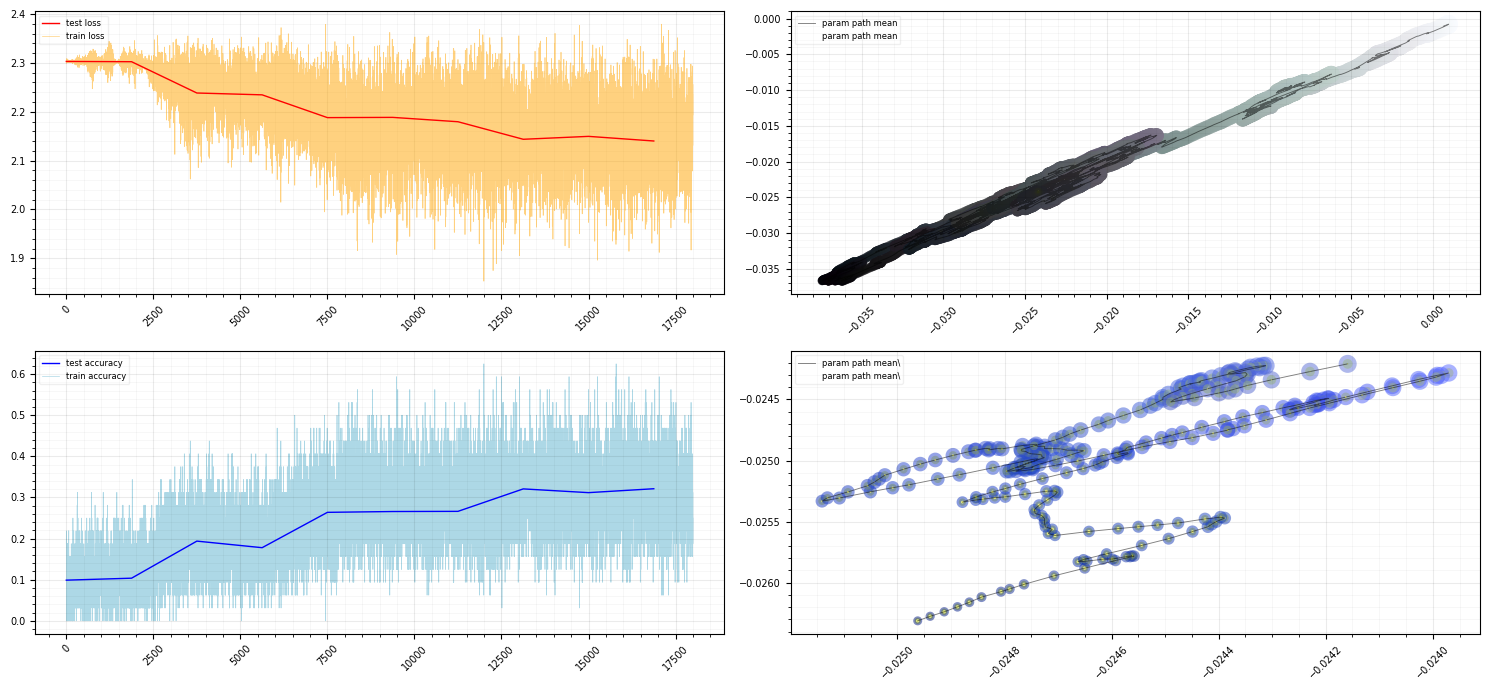

In [2]:
from torchzero.optim import RandomGrad
from torchzero.random import randgaussian_like
with seeded_rng(): MODEL = CNN()
MAGN = 1e-5
LR = 1e-3
BATCH_SIZE = 32
N_EPOCHS = 10
LOSS_FN = nn.CrossEntropyLoss()
METRIC_STEP = 1

OPT = RandomGrad(MODEL.parameters(), magn=MAGN, sampler=lambda x: randgaussian_like(x, sigma=3), opt=optim.AdamW(MODEL.parameters(), LR))
#SCHED = lr_scheduler.CosineAnnealingLR(OPT, N_EPOCHS)
SCHED = None

CALLBACKS = (Metric_Loss(),
            Metric_Accuracy(True,False),
            Log_ParamDist(METRIC_STEP),
            Log_ParamPath(METRIC_STEP),
            Log_UpdateDist(METRIC_STEP),
            Log_UpdatePath(METRIC_STEP),
            Log_LastUpdatesAngle(METRIC_STEP),
            #Log_GradDist(METRIC_STEP),
            #Log_GradUpdateAngle(METRIC_STEP),
            #Log_GradPath(METRIC_STEP),
            #Log_LastGradsAngle(METRIC_STEP),
            Log_Time(),
            #Log_LR(),
            Summary(),
            Accelerate("no"),
            PerformanceTweaks(True),
            Save_Last(),
            LivePlot(1000, plot_keys = ("4plotsplot","10metrics01"),path_keys=("4plotspath250",)),
            SimpleProgressBar(),
            PlotSummary(),
            GradientFreeWithZeroGrad(),
            OneBatch_ClosureWithNoBackward()
              )
clean_mem()

with seeded_rng():
    DLTRAIN = DataLoader(dstrain, BATCH_SIZE, shuffle=True, **seed0_kwargs)
    DLTEST = DataLoader(dstest, BATCH_SIZE, shuffle=False, **seed0_kwargs)

# MODEL = gnn.LSUV(MODEL, DLTRAIN, max_iter=5)

LEARNER_NAME = f"RandomGrad {MAGN:.0e} adamw{LR:.0e} - rademacher"
learner = Learner(MODEL, LEARNER_NAME, CALLBACKS, loss_fn=LOSS_FN, optimizer=OPT, scheduler=SCHED, )
learner.fit(N_EPOCHS, DLTRAIN, DLTEST,test_on_interrupt=False)

# Randconv 3x3
We use normally distributed random values convolved by a random normally-distributed 5x5 filter

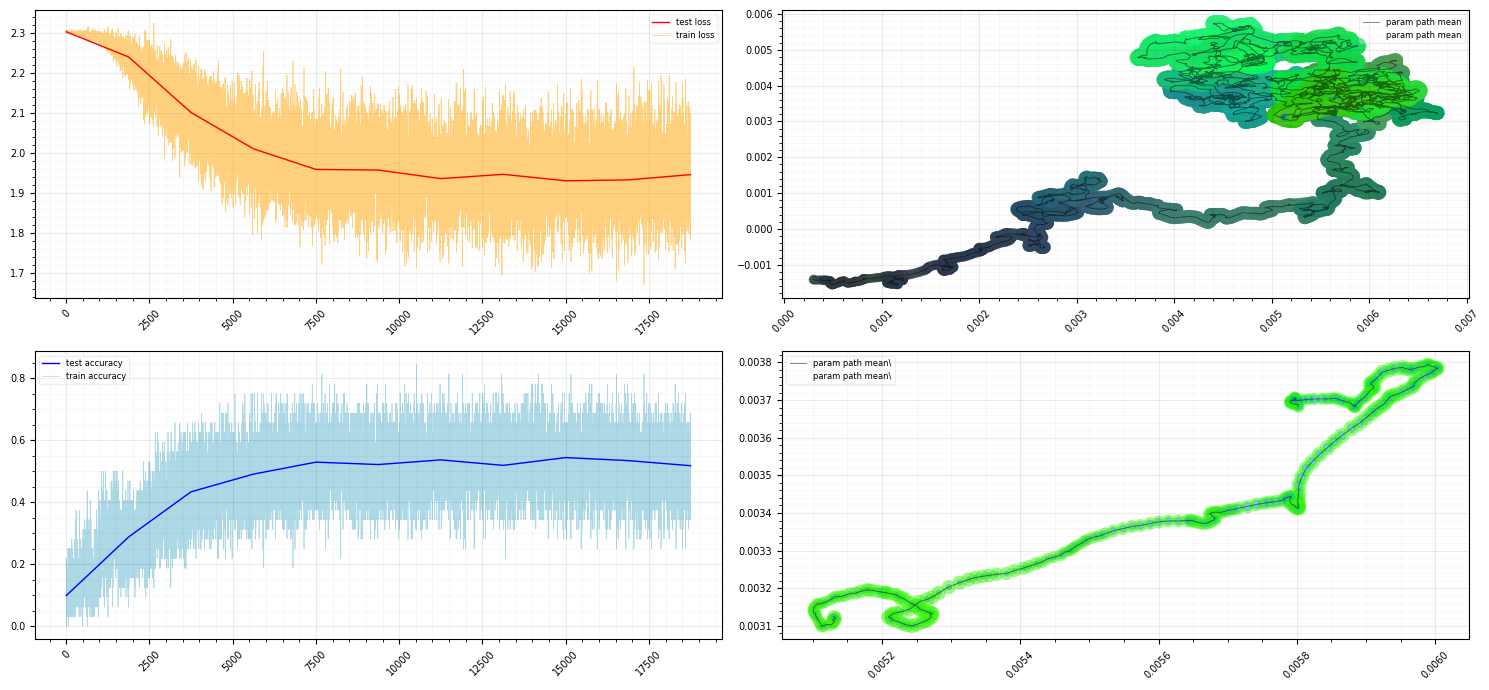

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉     | 10/10 | 01m:48s/ops, elapsed: 16m:13s, rem: 01m:48s | 

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 313/313 | 249.40ops/s, elapsed: 1.25s, rem: 4ms | 
train loss:                              last = 2.028, min = 1.670, max = 2.325
test loss:                               last = 1.932, min = 1.930, max = 2.303
train accuracy:                          last = 0.406, min = 0.000, max = 0.844
test accuracy:                           last = 0.534, min = 0.099, max = 0.544

test loss: min: 1.9301; max: 2.3029; last: 1.9456
test accuracy: min: 0.0989; max: 0.5438; last: 0.5177
param mean: min: -0.0000; max: 0.0046; last: 0.0027
param var: min: 0.0026; max: 0.0179; last: 0.0179
param min: min: -0.6300; max: -0.2488; last: -0.6300
param max: min: 0.2495; max: 0.5993; last: 0.5652
update var: min: 0.0000; max: 0.0000; last: 0.0000
update angle: min: 0.0016; max: 0.0195; last: 0.0017
time: min: 1.8924; max: 1087.5156; last: 1087.5156
train loss: min: 1.6696; max: 2.3246; last: 2.0279
train accuracy: min: 0.0000; max: 0.8438; last: 0.4062
last updates std: min: 0.0000; max: 0.0003; last: 0.0001


No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


In [2]:
from torchzero.optim import RandomGrad
from torchzero.random import randconv_like
from functools import partial
with seeded_rng(): MODEL = CNN()
MAGN = 1e-5
LR = 1e-3
BATCH_SIZE = 32
N_EPOCHS = 10
LOSS_FN = nn.CrossEntropyLoss()
METRIC_STEP = 1

OPT = RandomGrad(MODEL.parameters(), magn=MAGN, sampler=partial(randconv_like, kshape=5), opt=optim.AdamW(MODEL.parameters(), LR))
#SCHED = lr_scheduler.CosineAnnealingLR(OPT, N_EPOCHS)
SCHED = None

CALLBACKS = (Metric_Loss(),
            Metric_Accuracy(True,False),
            Log_ParamDist(METRIC_STEP),
            Log_ParamPath(METRIC_STEP),
            Log_UpdateDist(METRIC_STEP),
            Log_UpdatePath(METRIC_STEP),
            Log_LastUpdatesAngle(METRIC_STEP),
            #Log_GradDist(METRIC_STEP),
            #Log_GradUpdateAngle(METRIC_STEP),
            #Log_GradPath(METRIC_STEP),
            #Log_LastGradsAngle(METRIC_STEP),
            Log_Time(),
            #Log_LR(),
            Summary(),
            Accelerate("no"),
            PerformanceTweaks(True),
            Save_Last(),
            LivePlot(1000, plot_keys = ("4plotsplot","10metrics01"),path_keys=("4plotspath250",)),
            SimpleProgressBar(),
            PlotSummary(),
            GradientFreeWithZeroGrad(),
            OneBatch_ClosureWithNoBackward()
              )
clean_mem()

with seeded_rng():
    DLTRAIN = DataLoader(dstrain, BATCH_SIZE, shuffle=True, **seed0_kwargs)
    DLTEST = DataLoader(dstest, BATCH_SIZE, shuffle=False, **seed0_kwargs)

# MODEL = gnn.LSUV(MODEL, DLTRAIN, max_iter=5)

LEARNER_NAME = f"RandomGrad {MAGN:.0e} adamw{LR:.0e} - rademacher"
learner = Learner(MODEL, LEARNER_NAME, CALLBACKS, loss_fn=LOSS_FN, optimizer=OPT, scheduler=SCHED, )
learner.fit(N_EPOCHS, DLTRAIN, DLTEST,test_on_interrupt=False)

# Randconv 8x8
We use normally distributed random values convolved by a random normally-distributed 8x8 filter (which is very slow)

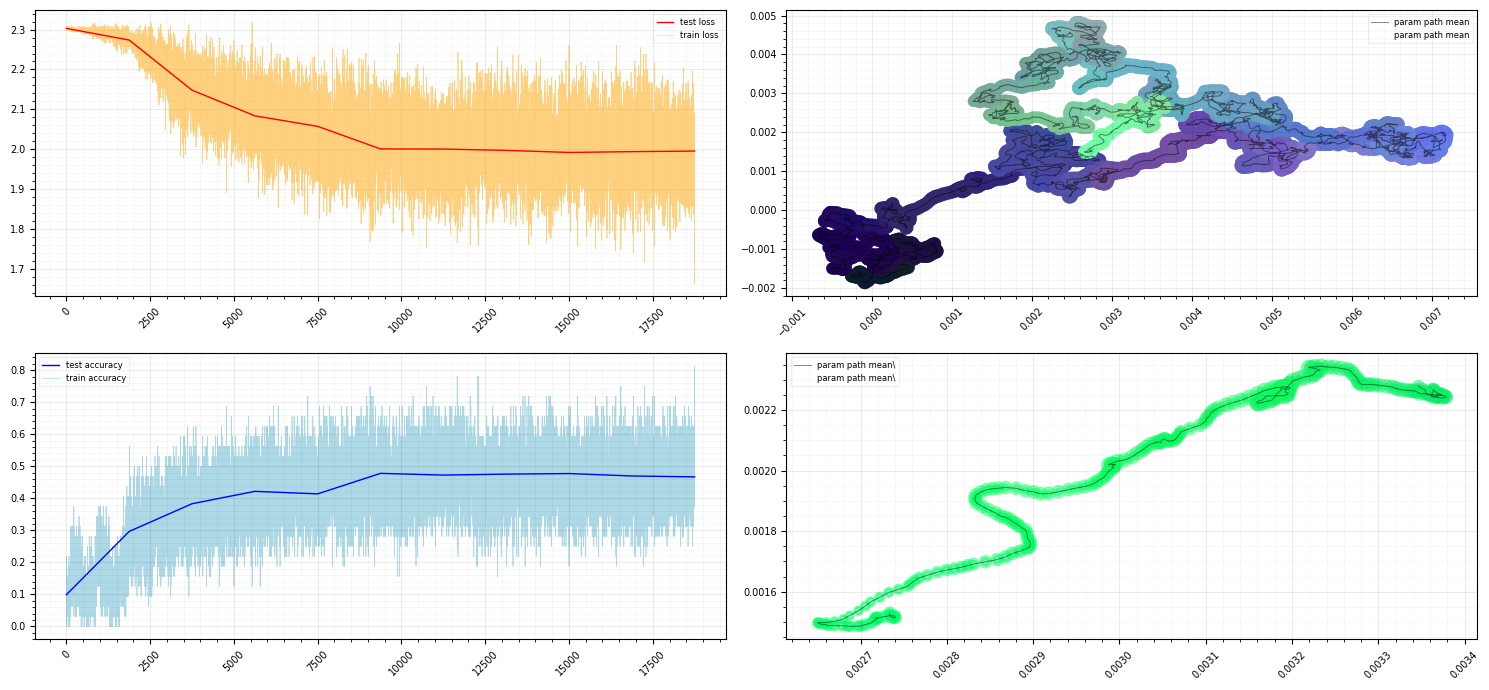

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉     | 10/10 | 08m:39s/ops, elapsed: 01h:17m:51s, rem: 08m:39s | 

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 313/313 | 233.03ops/s, elapsed: 1.34s, rem: 4ms | 
train loss:                              last = 1.846, min = 1.664, max = 2.316
test loss:                               last = 1.994, min = 1.992, max = 2.303
train accuracy:                          last = 0.594, min = 0.000, max = 0.812
test accuracy:                           last = 0.470, min = 0.099, max = 0.478

test loss: min: 1.9921; max: 2.3029; last: 1.9955
test accuracy: min: 0.0989; max: 0.4779; last: 0.4670
param mean: min: -0.0001; max: 0.0047; last: 0.0038
param var: min: 0.0026; max: 0.0177; last: 0.0177
param min: min: -0.5271; max: -0.2488; last: -0.5191
param max: min: 0.2458; max: 0.7013; last: 0.6813
update var: min: 0.0000; max: 0.0000; last: 0.0000
update angle: min: 0.0017; max: 0.0195; last: 0.0017
time: min: 2.9667; max: 5174.0156; last: 5174.0156
train loss: min: 1.6644; max: 2.3164; last: 1.8461
train accuracy: min: 0.0000; max: 0.8125; last: 0.5938
last updates std: min: 0.0001; max: 0.0003; last: 0.0001


No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


In [2]:
from torchzero.optim import RandomGrad
from torchzero.random import randconv_like
from functools import partial
with seeded_rng(): MODEL = CNN()
MAGN = 1e-5
LR = 1e-3
BATCH_SIZE = 32
N_EPOCHS = 10
LOSS_FN = nn.CrossEntropyLoss()
METRIC_STEP = 1

OPT = RandomGrad(MODEL.parameters(), magn=MAGN, sampler=partial(randconv_like, kshape=8), opt=optim.AdamW(MODEL.parameters(), LR))
#SCHED = lr_scheduler.CosineAnnealingLR(OPT, N_EPOCHS)
SCHED = None

CALLBACKS = (Metric_Loss(),
            Metric_Accuracy(True,False),
            Log_ParamDist(METRIC_STEP),
            Log_ParamPath(METRIC_STEP),
            Log_UpdateDist(METRIC_STEP),
            Log_UpdatePath(METRIC_STEP),
            Log_LastUpdatesAngle(METRIC_STEP),
            #Log_GradDist(METRIC_STEP),
            #Log_GradUpdateAngle(METRIC_STEP),
            #Log_GradPath(METRIC_STEP),
            #Log_LastGradsAngle(METRIC_STEP),
            Log_Time(),
            #Log_LR(),
            Summary(),
            Accelerate("no"),
            PerformanceTweaks(True),
            Save_Last(),
            LivePlot(1000, plot_keys = ("4plotsplot","10metrics01"),path_keys=("4plotspath250",)),
            SimpleProgressBar(),
            PlotSummary(),
            GradientFreeWithZeroGrad(),
            OneBatch_ClosureWithNoBackward()
              )
clean_mem()

with seeded_rng():
    DLTRAIN = DataLoader(dstrain, BATCH_SIZE, shuffle=True, **seed0_kwargs)
    DLTEST = DataLoader(dstest, BATCH_SIZE, shuffle=False, **seed0_kwargs)

# MODEL = gnn.LSUV(MODEL, DLTRAIN, max_iter=5)

LEARNER_NAME = f"RandomGrad {MAGN:.0e} adamw{LR:.0e} - rademacher"
learner = Learner(MODEL, LEARNER_NAME, CALLBACKS, loss_fn=LOSS_FN, optimizer=OPT, scheduler=SCHED, )
learner.fit(N_EPOCHS, DLTRAIN, DLTEST,test_on_interrupt=False)